# How good a simple model can predict without any feature engineering?

This section aims to establish a baseline of how good a simple model can predict without doing any extensive feature engineering. 

# Data preparation

In [1]:
import numpy as np
import pandas as pd
import featuretools as ft
import time
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the track information (mini version)

tf_df = pd.read_csv('../data/raw/data/track_features/tf_mini.csv')
log_df = pd.read_csv('../data/raw/data/training_set/log_mini.csv')

In [3]:
# perform some data cleaning/re-coding as described in 2_mini_EDA

tf_df_dummy = pd.get_dummies(tf_df, columns=['key','time_signature','mode'])
log_df_dummy = pd.get_dummies(log_df.drop(columns = ['session_length',  'hist_user_behavior_reason_end', 'hist_user_behavior_n_seekfwd','hist_user_behavior_n_seekback']), columns=['hist_user_behavior_reason_start', 'context_type'])


In [4]:
# perform a simple dataframe join
df = log_df_dummy.merge(tf_df_dummy, left_on = 'track_id_clean', right_on = 'track_id')
df.sort_values(by = ['session_id', 'session_position'],inplace = True)
df.head().T

,0,45,50,327,353
session_id,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e,0_00006f66-33e5-4de7-a324-2d18e439fc1e
session_position,1,2,3,4,5
track_id_clean,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,t_64f3743c-f624-46bb-a579-0f3f9a07a123
skip_1,False,False,False,False,False
skip_2,False,False,False,False,False
...,...,...,...,...,...
time_signature_3,0,0,0,0,0
time_signature_4,1,1,1,1,1
time_signature_5,0,0,0,0,0
mode_major,1,0,1,1,1


In [5]:
df.columns

Index(['session_id', 'session_position', 'track_id_clean', 'skip_1', 'skip_2',
       'skip_3', 'not_skipped', 'context_switch', 'no_pause_before_play',
       'short_pause_before_play', 'long_pause_before_play',
       'hist_user_behavior_is_shuffle', 'hour_of_day', 'date', 'premium',
       'hist_user_behavior_reason_start_appload',
       'hist_user_behavior_reason_start_backbtn',
       'hist_user_behavior_reason_start_clickrow',
       'hist_user_behavior_reason_start_endplay',
       'hist_user_behavior_reason_start_fwdbtn',
       'hist_user_behavior_reason_start_playbtn',
       'hist_user_behavior_reason_start_remote',
       'hist_user_behavior_reason_start_trackdone',
       'hist_user_behavior_reason_start_trackerror', 'context_type_catalog',
       'context_type_charts', 'context_type_editorial_playlist',
       'context_type_personalized_playlist', 'context_type_radio',
       'context_type_user_collection', 'track_id', 'duration', 'release_year',
       'us_popularity_es

In [6]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167880 entries, 0 to 134498
Data columns (total 76 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   session_id                                  167880 non-null  object        
 1   session_position                            167880 non-null  int64         
 2   track_id_clean                              167880 non-null  object        
 3   skip_1                                      167880 non-null  bool          
 4   skip_2                                      167880 non-null  bool          
 5   skip_3                                      167880 non-null  bool          
 6   not_skipped                                 167880 non-null  bool          
 7   context_switch                              167880 non-null  int64         
 8   no_pause_before_play                        167880 non-null  int64        

# Simple model 1: split the beginning/end of each sequence, random forest classifier, skip_2 (binary)

This model take the first 80% of tracks of each listening sequence as training dataset, and the last 20% of tracks as testing dataset. This approach respects the data's temporal order and test how generalizable the model is.

In [ ]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVC
import datetime

#from library.sb_utils import save_file

In [8]:
s_list = df['session_id'].unique()
print('# of sessions:',len(s_list))

# of sessions: 10000


In [9]:
# the beginning 'train_perc'% of the tracks of each session were taken as training dataset, 
# and the rest as testing dataset.

train_perc = 0.8

data_train_append = []
data_test_append = []
for s_id in s_list:
    temp = []
    temp = df.loc[df['session_id']==s_id,:]
    data_train_append.append(temp.iloc[0:round(len(temp)*train_perc),:])
    data_test_append.append(temp.iloc[round(len(temp)*train_perc):,:])

data_train = pd.concat(data_train_append)
data_test = pd.concat(data_test_append)

In [10]:
X_train = data_train.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id','track_id_clean','track_id','date'])
X_test = data_test.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id','track_id_clean','track_id','date'])

y_train = data_train['skip_2']
y_test = data_test['skip_2']

In [11]:
print('skip_2 rate in training dataset: ',y_train.mean())
print('skip_2 rate in testing dataset: ',y_test.mean())

skip_2 rate in training dataset:  0.5274078593003705
skip_2 rate in testing dataset:  0.4760951413374768


In [12]:
RF_sSplit = RandomForestClassifier(random_state=23, n_jobs = -1)
RF_sSplit.fit(X_train, y_train)
score_sSplit_train = RF_sSplit.score(X_train,y_train)
score_sSplit_test = RF_sSplit.score(X_test,y_test)
print('score_train',score_sSplit_train)
print('score_test',score_sSplit_test)

score_train 0.9963694258038597
score_test 0.7497758919500388


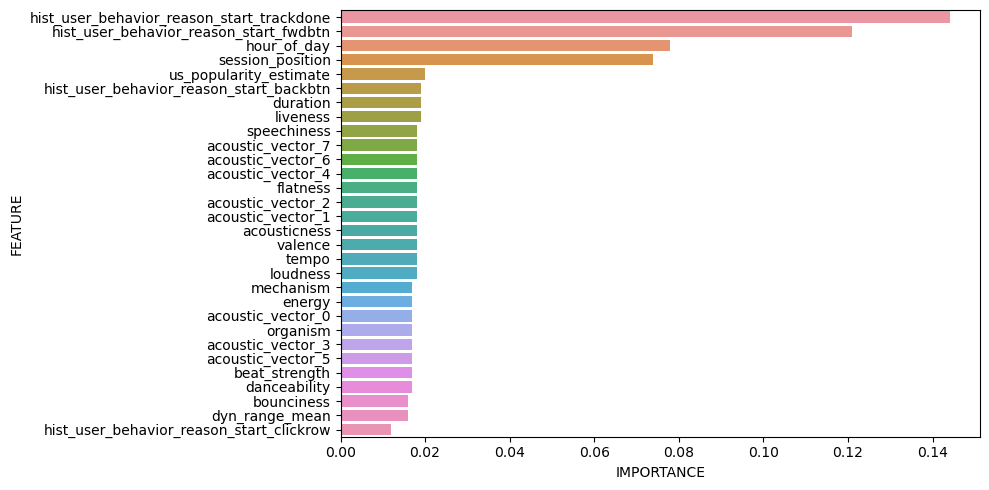

In [13]:
importances = pd.DataFrame({'FEATURE':X_train.columns,'IMPORTANCE':np.round(RF_sSplit.feature_importances_,3)})
importances = importances.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')

fig, ax = plt.subplots(figsize=(10,5)) 
sel_range = 30
sns.barplot(y = importances[0:sel_range].index, x = importances['IMPORTANCE'][0:sel_range], orient = 'h', ax = ax)

plt.tight_layout()
plt.show()

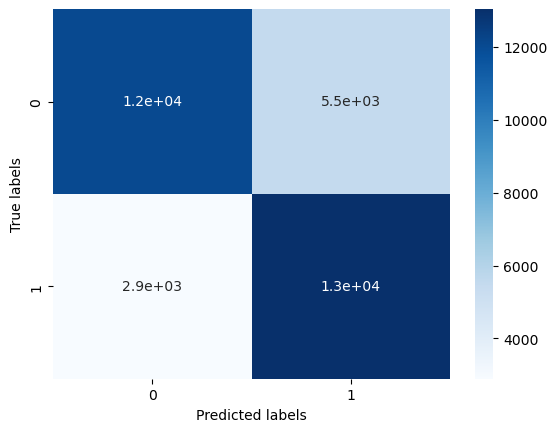

In [14]:
y_test_pred = RF_sSplit.predict(X_test)
pl = confusion_matrix(y_test,y_test_pred)
ax= plt.subplot()
p=sns.heatmap(pl, annot=True,cmap ='Blues',ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');

In [15]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

       False       0.81      0.69      0.74     17533
        True       0.70      0.82      0.76     15933

    accuracy                           0.75     33466
   macro avg       0.76      0.75      0.75     33466
weighted avg       0.76      0.75      0.75     33466



In [16]:
y_train_pred = RF_sSplit.predict(X_train)
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     63523
        True       1.00      1.00      1.00     70891

    accuracy                           1.00    134414
   macro avg       1.00      1.00      1.00    134414
weighted avg       1.00      1.00      1.00    134414



**Results of Simple Model 2:** Despite that the data was split according to the listening order, the prediction results are almost identical as random split. It is not surprising as the features did not contain any information regarding the listening history (yet), so the way of splitting the data should have no effect on the results.

# Simple model 3: split the beginning/end of each sequence, random forest classifier, muticlasses

This model will predict all the early and late skipping behavior.

In [38]:
def skip_label(df):
    skip = (df['not_skipped']==False).astype(int)*4 # no skip: 0, ultra-late skip: 4
    # It has to go under this order. If skip_1 = True, then skip_2 and _3 will be True too.
    skip[df['skip_3']==True] = 3 # late skip
    skip[df['skip_2']==True] = 2 # mid skip
    skip[df['skip_1']==True] = 1 # early skip
    return skip

#print(skip.head(20))
#print(df[['not_skipped','skip_1','skip_2','skip_3']].head(20))

In [39]:
data_train_append = []
data_test_append = []
for s_id in s_list:
    temp = []
    temp = df.loc[df['session_id']==s_id,:]
    data_train_append.append(temp.iloc[0:round(len(temp)*0.8),:])
    data_test_append.append(temp.iloc[round(len(temp)*0.8):,:])

data_train = pd.concat(data_train_append)
data_test = pd.concat(data_test_append)

X_train = data_train.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id','track_id_clean','track_id','date'])
X_test = data_test.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id','track_id_clean','track_id','date'])

y_train = skip_label(data_train)
y_test = skip_label(data_test)

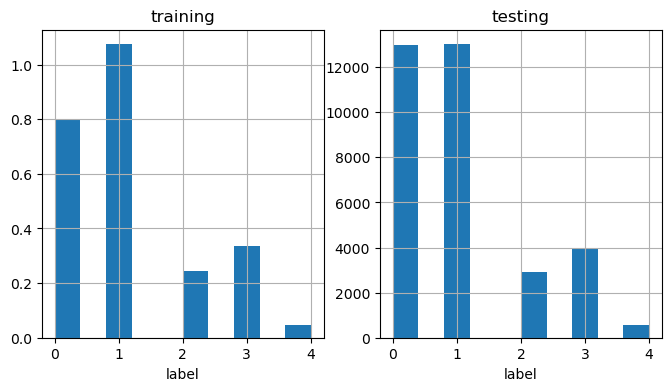

In [40]:
fig, (ax1, ax2) = plt.subplots(figsize=(8,4), ncols=2) 

y_train.hist(ax = ax1, density = True)
ax1.set_xlabel('label')
ax1.title.set_text('training')

y_test.hist(ax = ax2)
ax2.set_xlabel('label')
ax2.title.set_text('testing')

In [41]:
RF_MulClass = RandomForestClassifier(random_state=23, n_jobs = -1)
RF_MulClass.fit(X_train, y_train)
score_MulClass_train = RF_MulClass.score(X_train,y_train)
score_MulClass_test = RF_MulClass.score(X_test,y_test)
print('score_train',score_MulClass_train)
print('score_test',score_MulClass_test)

score_train 0.994472301992352
score_test 0.6213470387856331


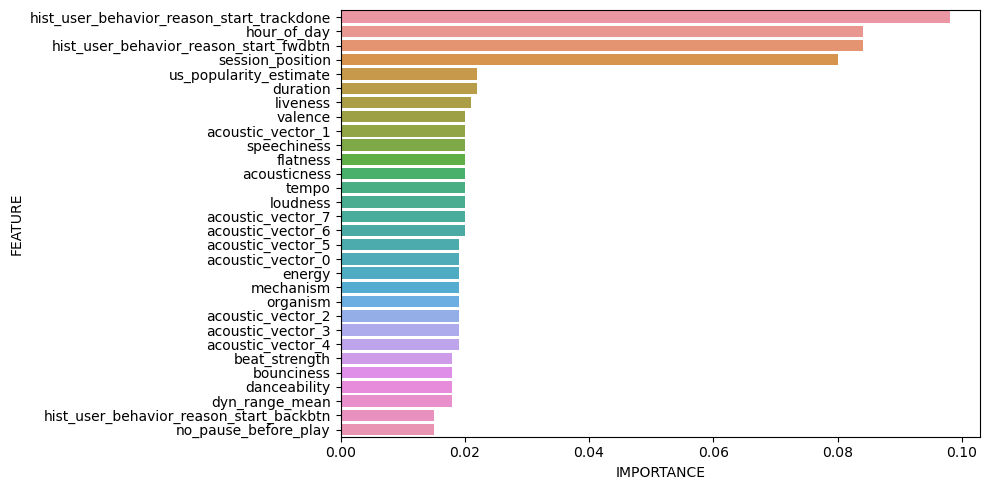

In [42]:
importances = pd.DataFrame({'FEATURE':X_train.columns,'IMPORTANCE':np.round(RF_MulClass.feature_importances_,3)})
importances = importances.sort_values('IMPORTANCE',ascending=False).set_index('FEATURE')

fig, ax = plt.subplots(figsize=(10,5)) 
sel_range = 30
sns.barplot(y = importances[0:sel_range].index, x = importances['IMPORTANCE'][0:sel_range], orient = 'h', ax = ax)

plt.tight_layout()
plt.show()

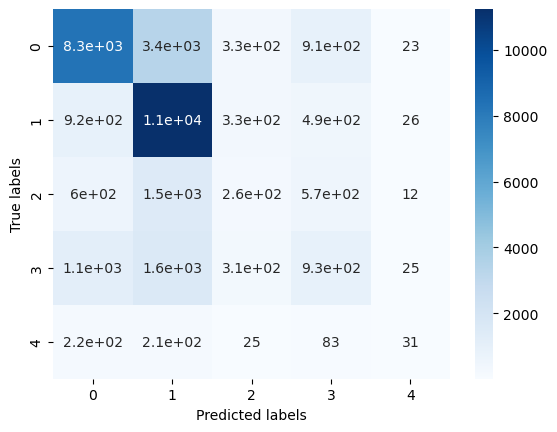

In [43]:
y_test_pred = RF_MulClass.predict(X_test)
pl = confusion_matrix(y_test,y_test_pred)
ax= plt.subplot()
p=sns.heatmap(pl, annot=True,cmap ='Blues',ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels');

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.74      0.64      0.69     12976
           1       0.63      0.86      0.73     13007
           2       0.21      0.09      0.12      2926
           3       0.31      0.23      0.27      3989
           4       0.26      0.05      0.09       568

    accuracy                           0.62     33466
   macro avg       0.43      0.38      0.38     33466
weighted avg       0.59      0.62      0.59     33466



**Results of Model 3:** The model performs relatively well for no skip (0) and early skip (1), which is likely because they have more cases. But in general the model performance is not so good, compared to binary classification.

# Simple model 4: split the beginning/end of each sequence, random forest classifier with hyperparameter tuning, skip_2 (binary)
Not sure whether it can still be called as a simple model, but the hyperparameter tunning will be implemented here.

In [17]:
s_list = df['session_id'].unique()
train_perc = 0.8

data_train_append = []
data_test_append = []
for s_id in s_list:
    temp = []
    temp = df.loc[df['session_id']==s_id,:]
    data_train_append.append(temp.iloc[0:round(len(temp)*train_perc),:])
    data_test_append.append(temp.iloc[round(len(temp)*train_perc):,:])

data_train = pd.concat(data_train_append)
data_test = pd.concat(data_test_append)

X_train = data_train.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id','track_id_clean','track_id','date'])
X_test = data_test.drop(columns=['not_skipped', 'skip_1', 'skip_2', 'skip_3', 'session_id','track_id_clean','track_id','date'])

y_train = data_train['skip_2']
y_test = data_test['skip_2']

In [18]:
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, roc_auc_score


param_grid = {'n_estimators':np.arange(20,200,20), 
             'max_depth':[np.arange(10,100,10),None], 
             'class_weight': ['balanced', None]}
RF_MulClass_pt = RandomForestClassifier(random_state=23, n_jobs = -1)
rf_cv= GridSearchCV(RF_MulClass_pt,
                    param_grid,
                    cv=5, 
                    n_jobs = 6)
rf_cv.fit(X_train,y_train)


pd.DataFrame(rf_cv.cv_results_).to_csv('../models/simpleModel/RF_skip2_GridSearchCV_20221121.csv')
# from joblib import dump, load
# dump(rf_cv, '../models/simpleModel/RF_skip2_GridSearchCV_20221121.joblib') 

['../models/simpleModel/RF_skip2_GridSearchCV_20221121.joblib']

In [19]:
pd.DataFrame(rf_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.633517,0.008629,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",20,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
1,0.329145,0.162989,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",40,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
2,0.384059,0.058509,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",60,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,30
3,0.534886,0.079295,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",80,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,27
4,0.371310,0.057066,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",100,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
5,0.512980,0.045986,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",120,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,34
6,0.442013,0.209407,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",140,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,33
7,0.426606,0.341663,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",160,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,32
8,0.280710,0.013909,0.000000,0.000000,balanced,"[10, 20, 30, 40, 50, 60, 70, 80, 90]",180,"{'class_weight': 'balanced', 'max_depth': [10,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,31
9,12.003906,0.204292,0.070793,0.004980,balanced,None,20,"{'class_weight': 'balanced', 'max_depth': None...",0.736227,0.737604,0.739984,0.733028,0.743546,0.738078,0.003541,17


In [20]:
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.7468046608891543
Best Parameters: {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 160}


In [21]:
pd.DataFrame(rf_cv.cv_results_).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_class_weight', 'param_max_depth', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

**Results of Model 4:** Without feature engineering, the best parameters of the random forest model are {'class_weight': None, 'max_depth': 10, 'n_estimators': 50}, and the best accuracy was 64.4%, which is only 2% better.

# Split each sequence: multi-class (SVM)

In [31]:
# clf = make_pipeline(StandardScaler(), SVC(verbose = True, random_state=23))
# clf.fit(X_train, y_train)

[LibSVM]..............................................................................................................................*..............................................................................................................................*.*
optimization finished, #iter = 252227
obj = -36073.929342, rho = 0.292277
nSV = 47263, nBSV = 30604
.................................................*................................*
optimization finished, #iter = 81440
obj = -23087.018105, rho = -0.397195
nSV = 28683, nBSV = 21009
.................................................................*...........................................*.*
optimization finished, #iter = 108221
obj = -29105.703096, rho = -0.295036
nSV = 35559, nBSV = 26185
......................................................................................*.........................................................................................*.*
optimization finished, #iter = 176460
obj = -22031.591988

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(random_state=23, verbose=True))])

In [32]:
# score_clf_train = clf.score(X_train,y_train)
# score_clf_test = clf.score(X_test,y_test)
# print('score_train',score_clf_train)
# print('score_test',score_clf_test)

score_train 0.6678768580653801
score_test 0.6515568039203968


In [33]:
# from joblib import dump, load
# dump(clf, '../models/simpleModel/SVC_simple.joblib') 

['../models/simpleModel/SVC_simple.joblib']